In [1]:
# ✅ 1. Import thư viện cần thiết
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# ✅ 2. Kiểm tra GPU trước khi chạy model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {DEVICE}")

✅ Using device: cuda


In [3]:
# ✅ 3. Cấu hình đường dẫn dataset 
# ✅ Set Paths
DATASET_PATH = "E:\CLD_project\Final_CLD_data"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

# ✅ 4. Cấu hình mô hình
IMG_SIZE = 224
BATCH_SIZE = 16  
EPOCHS = 3

# ✅ 5. Tiền xử lý ảnh
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ✅ 6. Load Dataset 
train_dataset = datasets.ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = datasets.ImageFolder(VAL_PATH, transform=transform)
test_dataset = datasets.ImageFolder(TEST_PATH, transform=transform)

# ✅ 7. Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train: {len(train_dataset)}, Validation: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 124999, Validation: 25000, Test: 5860


In [4]:
# ✅ 8. Load mô hình RegNetY-8GF 
from torchvision.models import regnet_y_8gf, RegNet_Y_8GF_Weights

model = regnet_y_8gf(weights=RegNet_Y_8GF_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))  # Điều chỉnh output layer
model = model.to(DEVICE)  # Chuyển model lên GPU

# ✅ Kiểm tra xem model có chạy trên GPU không
print(f"Model is running on: {next(model.parameters()).device}")

# ✅ 9. Cấu hình loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

# ✅ 10. Biến lưu loss & accuracy
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# ✅ 11. Hàm huấn luyện
def train(model, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        
        for images, labels in loop:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), acc=correct/total)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct / total)

        val_acc, val_loss = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_accs[-1]:.4f} | Val Acc: {val_acc:.4f} | Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

# ✅ 12. Hàm đánh giá mô hình
def evaluate(model, loader):
    model.eval()
    correct, total, total_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total, total_loss / len(loader)

# ✅ 13. Huấn luyện mô hình
train(model, train_loader, val_loader, EPOCHS)


Model is running on: cuda:0


Epoch 1/3: 100%|██████████| 7813/7813 [2:19:16<00:00,  1.07s/it, acc=0.991, loss=1.56e-5]   


Epoch 1/3 | Train Acc: 0.9909 | Val Acc: 0.9987 | Loss: 0.0303 | Val Loss: 0.0038


Epoch 2/3: 100%|██████████| 7813/7813 [2:08:09<00:00,  1.02it/s, acc=0.998, loss=0.00319]   


Epoch 2/3 | Train Acc: 0.9977 | Val Acc: 0.9994 | Loss: 0.0077 | Val Loss: 0.0030


Epoch 3/3: 100%|██████████| 7813/7813 [2:41:47<00:00,  1.24s/it, acc=0.999, loss=3.13e-5]   


Epoch 3/3 | Train Acc: 0.9985 | Val Acc: 0.9982 | Loss: 0.0049 | Val Loss: 0.0068


In [5]:

# ✅ 14. Đánh giá mô hình trên tập test
test_acc, test_loss = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 1.0000


In [6]:
# ✅ Save EfficientNet Model
torch.save(model.state_dict(),"regnety_8gf_coffee.pth" )

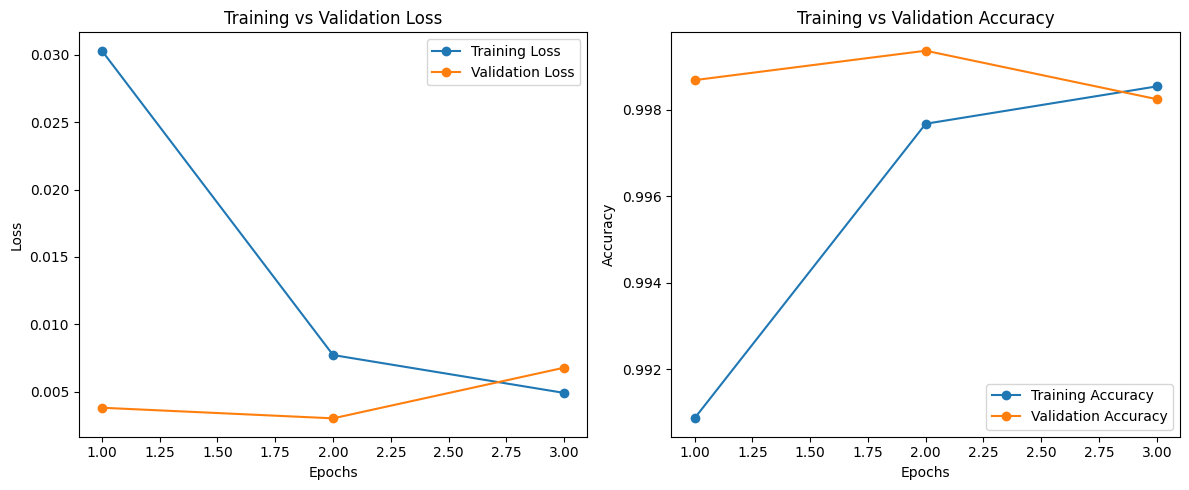

In [7]:
# ✅ 16. Trực quan hóa quá trình huấn luyện
plt.figure(figsize=(12, 5))

# Vẽ Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, label="Training Loss", marker="o")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Vẽ Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), train_accs, label="Training Accuracy", marker="o")
plt.plot(range(1, EPOCHS + 1), val_accs, label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()